# Introduction and related work

Although neural networks have proven to be invaluable in research as well as in automating various business processes, a lot of questions remain open as to how they work and why they are so effective. One model developed (by _Shwartz Ziv, Tishby_) to answer them is the **information plane**

From a statistical point of view, the data $X$ and labels $Y$ used to train a neural network that outputs prediction $\hat Y$ are two random variables drawn from some unknown distribution. The _activation value_ (output of the activation function) of each layer of the network $T_i \in \{T_1,T_2,...,T_n=\hat Y\}$ is a function of $X$ and, thus, a random variable as well.

![Information funnel model of a neural network](infofunnel.png)

As a way to understand this sequence of random variables, the original paper by _Schwartz-Ziv and Tishby_ proposes using _mutual information_:

$$
MI(X;Y) = - \sum_{x,y} p(x,y) \log \frac{p(x,y)}{p(x)p(y)}
$$

where $X$,$Y$ are distributions and $p(x)$, $p(y)$, $p(x,y)$ are probability mass functions

Every layer $T_i$ of a neural network thus is a point in the **information plane**: $(MI(X;T_i),MI(T_i;Y))$ where $MI(X;T_i) \geq MI(X; T_{i+1})$ and $MI(T_i; Y) \geq MI(T_{i+1};Y)$. This gives rise to an intuitive model of neural network being an **information funnel** that layer by layer extracts the most _relevant_ (informative of $Y$) information out of $X$ and discards the rest.

_Schwartz-Ziv and Tishby_ present certain that support the information funnel model as well as demonstrate that the process of _Stochastic Gradient Descent_ for a neural network tends to decompose into 2 stages:
* Fitting the network to the data ("moving the funnel"). During this stage $MI(\hat Y; Y)$ and $MI(\hat Y; X)$ grow.
* Compressing the output of the network ("shrinking the funnel"). During this stage $MI(\hat Y; Y)$ grows slower and $MI(\hat Y; X)$ shrinks.

**Our goal** in this project is to replicate these experiments as well as further explore this model with our own tools and experiments

# Experiments

Please note, that we ran a lot more than 3 experiments in the process of preparing this report, but here we omit small modifications of experimental setup that don't change the output as they are remarkably not interesting to read

## Estimating mutual information

According to the formula

$$
MI(X;Y) = - \sum_{x,y} p(x,y) \log \frac{p(x,y)}{p(x)p(y)}
$$

in order to estimate the mutual information between $X$, $Y$ and a layer, one _simply_ needs to estimate $p(x)$, $p(y)$ and $p(x,y)$ for all $x$ and $y$. Thus, we need The following procedure is used (**but not described**, one has to look through the code attached to the paper to find that out) in the original paper:
1. Given dataset X, Y estimate $p(x)=\frac{\text{count}(X=x)}{\text{count}(X)}$, $p(y)=\frac{\text{count}(Y=y)}{\text{count}(Y)}$ as well as joint $p(x,y)=\frac{\text{count}(X=x,Y=y)}{\text{count}(X,Y)}$
2. Run _all_ data points $x$ in $X$ through the neural network, obtain $T_i$ for all $i$
3. Repeat step 1 for every ($T_i$, $X$)

Note that this approach requires all random variales to be discrete, hence the activation values of neurons have to be discretized

Because the procedure is not described in the paper and the code is very hard to parse, we had to give up the idea of re-implementing it and make heavy use of it's API. However, we did implement an improvement upon the original estimation approach:

### Extended MI estimator

The model described above treats $X$, $Y$ and $T_i$ as random variables, but assumes the function $T(X)$ is completely deterministic. Which it is not, because we are training the neural network with _stochastic gradient descent_: every time we retrain it, the results will be slightly different.

We have implemented an MI estimator that accounts for this. Instead of working with one neural network, we can train several and sample elements of $T_i$ (activation values of neurons) randomly from several $T_{ij}$ ($i$ - layer, $j$ - index). From now on, this will be called _extended MI estimator_ and the original approach with one network - _simple MI estimator_. We will demonstrate the benefits of this approach further.

## Experimental setup

Every experiment was conducted as follows:
* Several copies of a neural network with identical architecture (number, size and type of layers) are created.
* They are trained iteratively using pytorch implementation of _Stochastic Gradient Descent_
* After each iteration of the algorithm, the full procedure _extended MI estimator_ is run and the estimated mutual information $MI(X;T_i)$, $MI(T_i;Y)$ is plotted on a graphical representation fo the **information plane**

Note that MI estimation is much more resource intensive than SGD itself and it doesn't run on the GPU. For this reason, going from primitive multi-layer perceptrons to experiments with more complicated neural networks is _very hard_.

In addition to the jupyter notebook with all experiments, 2 files are attached: 
- **information_process.py** contains methods for estimating mutual information. This code was made available by the authors of the original paper: we claim no credit for it.
- **experimental_setup.py** contains our tools for setting up experiments 

In [11]:
import numpy as np
import torch.optim
import torch
import torch.nn as nn
from torch.autograd import Variable

In [12]:
from experimental_setup import ZivInformationPlane, BufferedSequential, mutual_information_for_network_family, ReshapeLayer

In [290]:
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

def experiment(base_network, X, y, 
               epochs=100, lr=.2, batch_size=101, 
               network_copies=1, 
               plot='dynamic', 
               activation_bins=np.linspace(-1,1,50)):
    loss = torch.nn.MSELoss()
    network_copies = [copy.deepcopy(base_network) for _ in range(network_copies)]
    solvers = [torch.optim.SGD(params=network.parameters(), lr=lr) for network in network_copies]
    infoplane = ZivInformationPlane(X, y, bins=activation_bins)
    
    if plot == 'dynamic' or plot == 'once':
        fig = plt.figure(figsize=(12,5))
        graph = fig.add_subplot(111)
        graph.set_xlabel('I(X;T)')
        graph.set_ylabel('I(Y;T)')
        
    if plot == 'once':
        mi_history = [[] for _ in range(base_network.n_buffers)]
    
    for epoch in tqdm(range(epochs)):
        for network, solver in zip(network_copies, solvers):
            slice_ = np.random.permutation(range(len(X)))[:batch_size]
            X_batch = Variable(torch.from_numpy(X[slice_])).float()
            y_batch = Variable(torch.from_numpy(y[slice_, np.newaxis])).float()

            solver.zero_grad()
            pred_batch = network(X_batch)

            loss(pred_batch, y_batch).backward()
            solver.step()
        
        mi = mutual_information_for_network_family(infoplane, network_copies)
        
        if plot == 'dynamic':
            graph.scatter(*zip(*mi), s=10, c=np.linspace(0, 1, base_network.n_buffers), alpha=epoch/epochs)
            display.clear_output(wait=True)
            display.display(fig)
        elif plot == 'once':
            for history, new_point in zip(mi_history, mi):
                history.append(new_point)
        
    if plot == 'once':
        for history in mi_history:
            graph.plot(*zip(*history))
            
    return network_copies

## Data

In order to replicate _Tishby an Schwartz-Ziv's_ original experiment, we'll generate synthetic test data using a simple binary decision function with small Gaussian noise

In [18]:
X = np.random.randint(5, size=(1000, 12)) - 1
y = (np.mean(X, axis=1) + np.random.normal(scale=0.1, size=1000) > 0.7).astype(np.int)
Y = y.reshape(-1, 1)

And another, more complicated decision function, in order to compare the results.

In [19]:
y_complicated = np.sum(X[:,2::2] * X[:,3::2]) - X[:,0] * X[:,0]
y_complicated = y_complicated + np.random.normal(size=1000, scale=0.2) > np.mean(y_complicated)
y_complicated = y_complicated * 2 - 1
Y_complicated = y_complicated.reshape(-1, 1)

And finally, MNIST dataset of hand-written digits, to test if the results generalize from the synthetic dataset to a more realistic one

In [3]:
import sklearn.datasets as datasets
mnist = datasets.fetch_mldata('MNIST original', data_home='data')

In [41]:
index = np.random.randint(mnist.data.shape[0], size=1000)

In [266]:
X_mnist = mnist.data[index]
X_mnist = X_mnist.reshape(-1, 28, 28)
X_mnist = X_mnist[:,0::2,0::2] + X_mnist[:,1::2,0::2] + X_mnist[:,0::2,1::2] + X_mnist[:,1::2,1::2]
X_mnist = (X_mnist / 20).astype(np.int64).reshape(-1, 14 * 14)

In [267]:
y_mnist = mnist.target[index]
Y_mnist = np.zeros((y_mnist.shape[0], 10))
Y_mnist[np.arange(y_mnist.shape[0]), y_mnist.astype(np.int)] = 1

## Experiment 1: Warm up

Two-layer perceptron, simple MI estimator, simple synthetic data

In [49]:
layers = [
    nn.Linear(12, 5),
    nn.Tanh(),
    nn.Linear(5, 1),
    nn.Tanh()
    ]
buffer_mask = [False, True, False, True]
architecture = BufferedSequential(layers, buffer_mask)

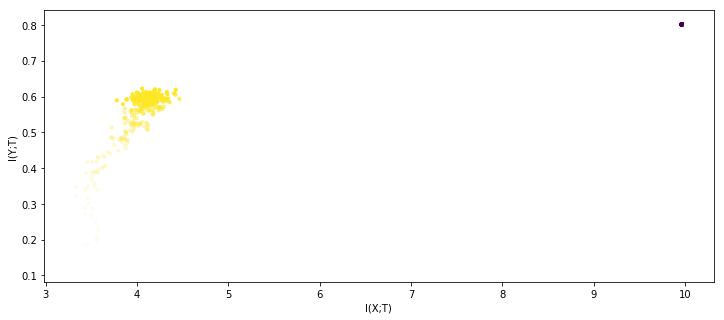

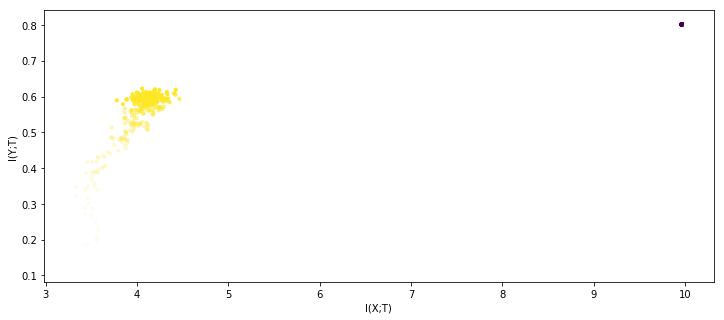

In [50]:
result_1layer = experiment(architecture, X, Y, epochs=300, network_copies=1, plot='dynamic')[0]

Different colors represent different layers of the neural network. As one can see, this network is too simple for the observations of _Schvartz-Ziv and Tishby_ to manifest.

## Experiment 2: As close to Tishby setup as possible

Six-layer perceptron, simple MI estimator, simple synthetic dataset

In [116]:
layers = [
    nn.Linear(12, 10),
    nn.Tanh(),
    nn.Linear(10, 7),
    nn.Tanh(),
    nn.Linear(7, 5),
    nn.Tanh(),
    nn.Linear(5, 4),
    nn.Tanh(),
    nn.Linear(4, 3),
    nn.Tanh(),
    nn.Linear(3, 1),
    nn.Tanh()
    ]
buffer_mask = [False, True, False, True, False, True, False, True, False, True, False, True]
tishby_architecture = BufferedSequential(layers, buffer_mask)

100%|██████████| 1000/1000 [11:10<00:00,  1.49it/s]


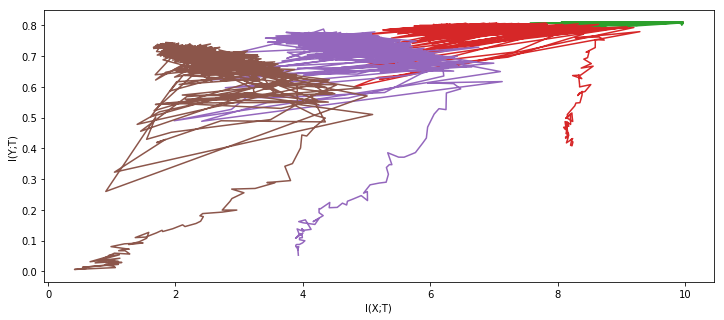

In [117]:
result_nets = experiment(tishby_architecture, X, Y * 2 - 1, epochs=1000, network_copies=1, plot='once')

For comparison, here are the results from the original paper:

![2 Stages](2stages.png)

Indeed, the experiment reproduces successfully. But what if we use the same network architecture and the same data, but with our _extended MI estimator_ ?

100%|██████████| 1000/1000 [11:46<00:00,  1.42it/s]


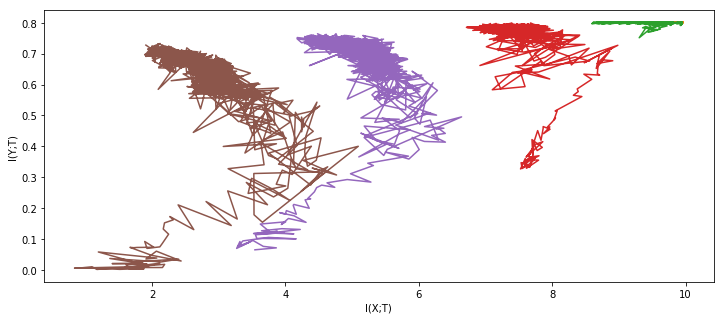

In [69]:
result_nets = experiment(tishby_architecture, X, Y * 2 - 1, epochs=1000, network_copies=5, plot='once')

Feel free to take a second to process the awe and admiration of this clearly superior method you are experiencing at the moment.

## Experiment 3: Another dataset

Six-layer perceptron, extended MI estimator, complicated synthetic dataset

100%|██████████| 200/200 [02:31<00:00,  1.32it/s]


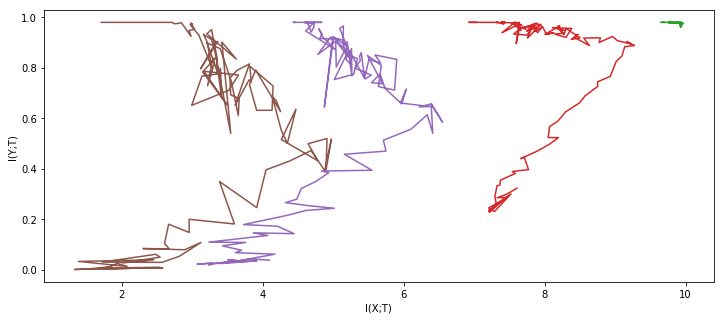

In [97]:
result_nets = experiment(tishby_architecture, X, Y_complicated, epochs=200, network_copies=5, plot='once')

Results reproduce

## Experiment 4: (Almost) Real-world problem

For this experiment we will use:
* MNIST dataset of hand-written digits
* Convolutional neural network (1 conv layer, 1 ReLU layer, 2 fully connected layer)
* Extended mutual information estimator

In [292]:
layers = [
    ReshapeLayer((-1, 1, 14, 14)),
    nn.Conv2d(1, 1, (4,4)),
    nn.MaxPool2d((3, 3)),
    ReshapeLayer((-1, 9)),
    nn.ReLU(),
    nn.Linear(9, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Softmax(dim=1)
    ]
buffer_mask = [False, False, False, False, False, False, True, False, True]
conv_architecture = BufferedSequential(layers, buffer_mask)

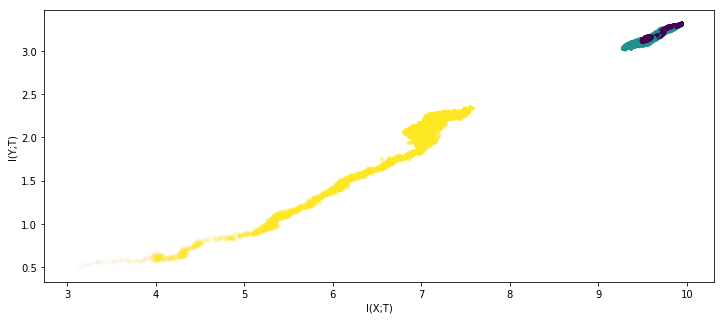

100%|██████████| 6000/6000 [4:44:41<00:00,  2.85s/it]


[BufferedSequential(
 ), BufferedSequential(
 ), BufferedSequential(
 )]

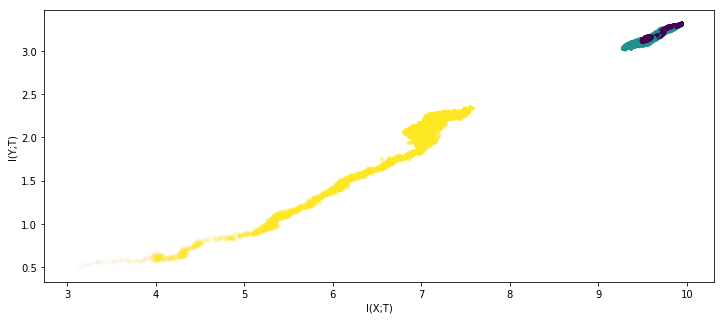

In [294]:
experiment(conv_architecture, X_mnist, Y_mnist, epochs=6000, network_copies=3, plot='dynamic')

## Bonus: mutual information stopping criterion

It felt wrong to end this project without a more or less practical (i.e. code you can use) result, so here it is: an algorithm for training neural networks that uses mutual information profile of the last layer $I(X; \hat Y) - \beta I(\hat Y; Y)$ as its stopping criterion. Because, as already mentioned, MI estimators are very slow, we do not check this criterion at every iteration.

Code is attached

In [ ]:
from tqdm import tqdm

def fit(network, 
        X, 
        y, 
        epochs=10, 
        epoch_length=10, 
        mi_tol=0.1, 
        beta = 1, 
        lr=.2, 
        batch_size=101, 
        activation_bins=np.linspace(-1,1,50), 
        loss = torch.nn.MSELoss()):
    """Use the mutual information of the last layer 
       as a stopping criterion when fitting a neural net"""
    
    solver = torch.optim.SGD(params=network.parameters(), lr=lr)
    infoplane = ZivInformationPlane(X, y, bins=activation_bins)
    mi_last = 10e-20
    
    for epoch in tqdm(range(epochs)):
        for _ in range(epoch_length):
            slice_ = np.random.permutation(range(len(X)))[:batch_size]
            X_batch = Variable(torch.from_numpy(X[slice_])).float()
            y_batch = Variable(torch.from_numpy(y[slice_, np.newaxis])).float()

            solver.zero_grad()
            pred_batch = network(X_batch)

            loss(pred_batch, y_batch).backward()
            solver.step()
        
        mi_x, mi_y = mutual_information_for_network_family(infoplane, network_copies)[-1]
        mi = mi_y - beta * mi_x 
        if mi - mi_last < tol * mi_last:
            break

## Conclusions

* Original experiment **replicated successfuly**
* Small changes to the original experiment didn't change the results, but on very different (like the convolutional one) neural networks, the experiment turned out hard to reproduce. However, we cannot conclude that _Shwartz-Ziv and Tishby's_ results were erroneous , because there are other possible explanations like not having enough time and resources to run the experiment till stage 2

We have also introduced:
* An improvement of the mutual information estimator with several neural networks
* A new stopping criterion for neural network optimization

# Contributions

* **Vadim** - almost everything
* **Leonid** - a few slides, thoughts and prayers, valuable feedback

# References

* _Ravid Shwartz-Ziv, Naftali Tishby_ Opening the Black Box of Deep Neural Networks via Information
* _Dan C. Cireşan, Ueli Meier, Jonathan Masci, Luca M. Gambardella, Jürgen Schmidhuber_ Flexible, High Performance Convolutional Neural Networks for Image Classification